# Football match prediction

## The notebook is used to analyse football match results of major european leagues - and create a predictive model to identify the result of a game - win by home team, win by away team and a draw

#### Import basic packages

In [1]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

#### Install packages for profiling (ydata-profiling) and feature importance (SHAP)

In [2]:
!pip install shap


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install ydata-profiling


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import shap
from pandas_profiling import ProfileReport

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
`import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.


In [5]:
pd.options.mode.chained_assignment = None 

#### Read training dataset

In [6]:
train_data = pd.read_csv('../train.csv')

In [7]:
train_data.shape

(12789, 19)

In [8]:
train_data.columns

Index(['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'Date', 'FTR', 'HC',
       'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HY', 'HomeTeam', 'league'],
      dtype='object')

In [9]:
train_data.describe()

,AC,AF,AR,AS,AST,AY,HC,HF,HR,HS,HST,HTAG,HTHG,HY
count,12780.000000,12778.000000,12780.000000,12780.000000,12780.000000,12780.000000,12780.000000,12778.000000,12780.000000,12780.000000,12780.000000,12779.000000,12779.000000,12779.000000
mean,4.497966,14.411802,0.140063,11.234898,4.177465,2.173552,5.791080,13.917123,0.101252,14.061033,5.268545,0.494796,0.691134,1.862431
std,2.582074,4.668766,0.377728,4.526805,2.497475,1.367718,3.012718,4.572456,0.320539,5.170604,2.872875,0.713903,0.833159,1.313217
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,11.000000,0.000000,8.000000,2.000000,1.000000,4.000000,11.000000,0.000000,10.000000,3.000000,0.000000,0.000000,1.000000
50%,4.000000,14.000000,0.000000,11.000000,4.000000,2.000000,5.000000,14.000000,0.000000,14.000000,5.000000,0.000000,0.000000,2.000000
75%,6.000000,17.000000,0.000000,14.000000,6.000000,3.000000,8.000000,17.000000,0.000000,17.000000,7.000000,1.000000,1.000000,3.000000
max,19.000000,34.000000,3.000000,39.000000,20.000000,9.000000,21.000000,38.000000,3.000000,43.000000,24.000000,5.000000,5.000000,8.000000


### Feature Engineering : Change column names for readability

In [10]:
list_of_old_column_names = ['HomeTeam'
,'AwayTeam'
,'FTR'
,'HTHG'
,'HTAG'
,'HS'
,'AS'
,'HST'
,'AST'
,'AC'
,'HF'
,'AF'
,'HC'
,'HY'
,'AY'
,'HR'
,'AR'
,'Date'
,'league']


In [11]:
list_of_meaningful_column_name = ['HomeTeam'
,'AwayTeam'
,'Full-TimeResult'
,'HalfTimeHomeTeamGoals'
,'HalfTimeAwayTeamGoals'
,'HomeTeamShots'
,'AwayTeamShots'
,'HomeTeamShotsonTarget'
,'AwayTeamShotsonTarget'
,'AwayTeamCorners'
,'HomeTeamFoulsCommitted'
,'AwayTeamFoulsCommitted'
,'HomeTeamCorners'
,'HomeTeamYellowCards'
,'AwayTeamYellowCards'
,'HomeTeamRedCards'
,'AwayTeamRedCards'
,'Date'
,'league'
]

In [12]:
def convert_column_names(df,old_col_names,new_col_names):
    """
    Convert column headers to meaningful, readable names
    
    Input
    ------
    df : dataframe
    old_names : list of old names for columns
    new_col_names : list of new names for columns, same order as old_names
    
    """
    for i in range(len(new_col_names)):
        old_col = old_col_names[i]
        new_meaningful_col = new_col_names[i]
        if old_col in df.columns:
            df[new_meaningful_col] = df[old_col]
            if old_col != new_meaningful_col:
                df = df.drop(old_col,axis=1)
    return df
    

In [13]:
train_data = convert_column_names(train_data,old_col_names = list_of_old_column_names,new_col_names = list_of_meaningful_column_name)

In [14]:
train_data

,AwayTeam,Date,HomeTeam,league,Full-TimeResult,HalfTimeHomeTeamGoals,HalfTimeAwayTeamGoals,HomeTeamShots,AwayTeamShots,HomeTeamShotsonTarget,AwayTeamShotsonTarget,AwayTeamCorners,HomeTeamFoulsCommitted,AwayTeamFoulsCommitted,HomeTeamCorners,HomeTeamYellowCards,AwayTeamYellowCards,HomeTeamRedCards,AwayTeamRedCards
0,Stuttgart,07/08/09,Wolfsburg,bundesliga,H,0.0,0.0,13.0,14.0,7.0,4.0,3.0,12.0,12.0,6.0,0.0,0.0,0.0,0.0
1,FC Koln,08/08/09,Dortmund,bundesliga,H,0.0,0.0,24.0,7.0,11.0,0.0,1.0,8.0,10.0,16.0,0.0,1.0,0.0,0.0
2,Hannover,08/08/09,Hertha,bundesliga,H,0.0,0.0,10.0,15.0,4.0,3.0,3.0,16.0,20.0,5.0,3.0,2.0,0.0,0.0
3,Bayern Munich,08/08/09,Hoffenheim,bundesliga,D,1.0,1.0,9.0,9.0,1.0,3.0,10.0,10.0,28.0,3.0,0.0,2.0,0.0,0.0
4,Leverkusen,08/08/09,Mainz,bundesliga,D,1.0,2.0,8.0,13.0,4.0,7.0,5.0,22.0,28.0,3.0,1.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12784,Udinese,28/05/17,Inter,serie-a,H,3.0,0.0,17.0,17.0,6.0,4.0,7.0,15.0,1.0,6.0,2.0,1.0,0.0,0.0
12785,Empoli,28/05/17,Palermo,serie-a,H,0.0,0.0,10.0,17.0,5.0,4.0,7.0,18.0,16.0,0.0,3.0,4.0,0.0,0.0
12786,Genoa,28/05/17,Roma,serie-a,H,1.0,1.0,24.0,13.0,7.0,4.0,2.0,8.0,14.0,6.0,2.0,0.0,0.0,0.0
12787,Napoli,28/05/17,Sampdoria,serie-a,A,0.0,2.0,12.0,22.0,2.0,7.0,10.0,9.0,8.0,5.0,1.0,0.0,0.0,0.0


## Run profile report by using y-data profiling

In [15]:
profile = ProfileReport(train_data)
profile.to_file(output_file="profile_report.html")

Export report to file: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


#### From profile report we saw that only 0.1% records are having null, hence safe to remove all rows containing null

## <font color='red'> Design Considerations

##### Question
Before we delve into details of the modelling - here one of the important thing would be to understand ***what would be the use of the model, and at what point of time?***

looking at the data, we have features from half time (no. of goals) - so it might seem that we would be using the model to place a bet at half time. 

However we are having features like 'Home team shots' - which are likely to be end-of-game result. In that case ***what would be the benefit of predicting the result when we have already reached the end of game?***

In other words, we may need to build a model which will have features at half time plus all features from earlier games and then it would try to predict the result of the current game. The current game's end-stats like no of shots, corners, fouls, etc can not be used for prediction



### Alternative option

We can create a different model where a match result can be predicted with the information at the point of half time

For that kind of model it would be best to create a timeseries of matches and then to predict the outcome of match by looking at the past N performances of the home and away team

The possible structure of the model would be : 
    1. Input features for home team's past performance - aggregates of all available features, rolll-up and trend features
    2. Similarly, input features for away team's past performance
    3. Score at half time
    4. Target : What would be the result at full time?
    
    
For this kind of model - would be ideal to use continuous match data from past 3-4 years history. The model would have wide features and probably we can try LSTM based model or lightGBM model, depending on how we would want to use the model in production

#### <font color='red'> But this kind of model would take longer time to build

## <font color='red'> For the sake of time and simplicity, currently I am building a simplistic model which will take all inputs and predict the result of the current game

In [16]:

train_data = train_data.dropna(how='any',axis=0)

### Numeric features

In [17]:
list_of_numeric_features = ['HalfTimeHomeTeamGoals'
,'HalfTimeAwayTeamGoals'
,'HomeTeamShots'
,'AwayTeamShots'
,'HomeTeamShotsonTarget'
,'AwayTeamShotsonTarget'
,'AwayTeamCorners'
,'HomeTeamFoulsCommitted'
,'AwayTeamFoulsCommitted'
,'HomeTeamCorners'
,'HomeTeamYellowCards'
,'AwayTeamYellowCards'
,'HomeTeamRedCards'
,'AwayTeamRedCards']

In [18]:
len(list_of_numeric_features)

14

### Thoughts on feature engineering

    1. The performance of teams can be extrapolated from their shots accuracy
    2. Total number of cards may indicate how aggressive a team is playing
    3. The more number of fouls a team commits, generally indicates the opponent is keeping high pressure on the attack
    

### Feature Engineering : Create new columns 
    - ratio of shots on target against total shots
    - total cards
    - ratio of home team fouls against total fouls
    - uplift of the percentage of shots on target between home and away team
As example - if home team is having 30% shots on target and away team is having 10% shots on target
then uplift = 30/10 = 3


In [19]:
def feat_eng_create_derived_feats(df):
    """
    Create derived features from base features
        - ratio of shots on target (home and away)
        - total cards (home and away)
        - ratio of fouls committed by home team against total fouls
        - ratio of corners by home team against total corners
        - uplift of the percentage of shots on target between home and away team
    """
    df['HalfTimeHomeTeamGoalDiff'] = df['HalfTimeHomeTeamGoals']-df['HalfTimeAwayTeamGoals']
    df['HomeTeamShotsOntargetRatio'] = df['HomeTeamShotsonTarget']/df['HomeTeamShots']
    df['AwayTeamShotsOntargetRatio'] = df['AwayTeamShotsonTarget']/df['AwayTeamShots']
    df['HomeTeamTotalCards'] = df['HomeTeamRedCards']+df['HomeTeamYellowCards']
    df['AwayTeamTotalCards'] = df['AwayTeamRedCards']+df['AwayTeamYellowCards']
    df['HomeTeamCornersRatio'] = df['HomeTeamCorners']/(df['HomeTeamCorners']+df['AwayTeamCorners'])
    df['HomeTeamFoulsRatio'] = df['HomeTeamFoulsCommitted']/(df['HomeTeamFoulsCommitted']+df['AwayTeamFoulsCommitted'])
    df['HomeTeamShotsOntargetUpliftThanAwayTeam'] = df['HomeTeamShotsOntargetRatio']/df['AwayTeamShotsOntargetRatio']
    
    
    ### Handle null and infinity
    
        # For null values, fill by 0

    
    df['HomeTeamFoulsRatio'] = df['HomeTeamFoulsRatio'].fillna(0)
    df['HomeTeamCornersRatio'] = df['HomeTeamCornersRatio'].fillna(0)
    df['HomeTeamShotsOntargetUpliftThanAwayTeam'] = df['HomeTeamShotsOntargetUpliftThanAwayTeam'].fillna(0)
    
        # For infinity, fill by max
    
    max_foul_ratio = df.loc[df['HomeTeamFoulsRatio'] != np.inf, 'HomeTeamFoulsRatio'].max()
    df['HomeTeamFoulsRatio'].replace(np.inf,max_foul_ratio,inplace=True)

    max_corn_ratio = df.loc[df['HomeTeamCornersRatio'] != np.inf, 'HomeTeamCornersRatio'].max()
    df['HomeTeamCornersRatio'].replace(np.inf,max_corn_ratio,inplace=True)

    max_sot_uplift = df.loc[df['HomeTeamShotsOntargetUpliftThanAwayTeam'] != np.inf, 'HomeTeamShotsOntargetUpliftThanAwayTeam'].max()
    df['HomeTeamShotsOntargetUpliftThanAwayTeam'].replace(np.inf,max_sot_uplift,inplace=True)
    
    
    return df

In [20]:
train_data = feat_eng_create_derived_feats(train_data)

### Feature Engineering : Convert date like string to date format

#### First convert 2 digit years to 4 digit year

In [21]:
import re

In [22]:
def convert_to_full_date(astring):
    """
    Convert date in format of 'dd/mm/yy' to 'dd/mm/yyyy'
    """
    full_date = str(re.split("/", astring)[0])+"/"+\
        str(re.split("/", astring)[1])+"/"+\
        str(2000+int(re.split("/", astring)[2]))
    return full_date

#### Convert to date time format

In [23]:
def feat_eng_convert_date_to_format(df):
    """
    Convert date as string column to date format
        Take dataframe and first convert date column format of 'dd/mm/yy' to 'dd/mm/yyyy'
        Then convert string format of 'dd/mm/yyyy' to python date format
    """
    ## Apply function to convert 2 digit year to 4 digit year
    df['full_date'] = df['Date'].apply(lambda x: convert_to_full_date(x))
    ## Convert from string to date
    df['date'] = pd.to_datetime(df['full_date'], format='%d/%m/%Y')
    
    ## drop other date columns
    df = df.drop(['Date','full_date'],axis = 1)
    
    return df

In [24]:
train_data = feat_eng_convert_date_to_format(train_data)

#### Define set of numeric columns to be taken for modelling

In [25]:
#### List of columns which would be excluded
columns_to_exclude_from_numeric = ['AwayTeam', 'HomeTeam', 'league', 'Full-TimeResult','date', 'HomeTeamWin',
 'AwayTeamWin', 'Draw']

#### List of numeric features
extended_list_of_numeric_features = [col for col in train_data.columns if col not in columns_to_exclude_from_numeric]

#### Get list of full numeric features

#### Fill nulls with zeros (the first N games for each of home team and away team would have nulls)

In [26]:
train_data = train_data.fillna(0)

In [27]:
len(extended_list_of_numeric_features)

22

In [28]:
extended_list_of_numeric_features

['HalfTimeHomeTeamGoals',
 'HalfTimeAwayTeamGoals',
 'HomeTeamShots',
 'AwayTeamShots',
 'HomeTeamShotsonTarget',
 'AwayTeamShotsonTarget',
 'AwayTeamCorners',
 'HomeTeamFoulsCommitted',
 'AwayTeamFoulsCommitted',
 'HomeTeamCorners',
 'HomeTeamYellowCards',
 'AwayTeamYellowCards',
 'HomeTeamRedCards',
 'AwayTeamRedCards',
 'HalfTimeHomeTeamGoalDiff',
 'HomeTeamShotsOntargetRatio',
 'AwayTeamShotsOntargetRatio',
 'HomeTeamTotalCards',
 'AwayTeamTotalCards',
 'HomeTeamCornersRatio',
 'HomeTeamFoulsRatio',
 'HomeTeamShotsOntargetUpliftThanAwayTeam']

#### Plot distributions for few of the top features

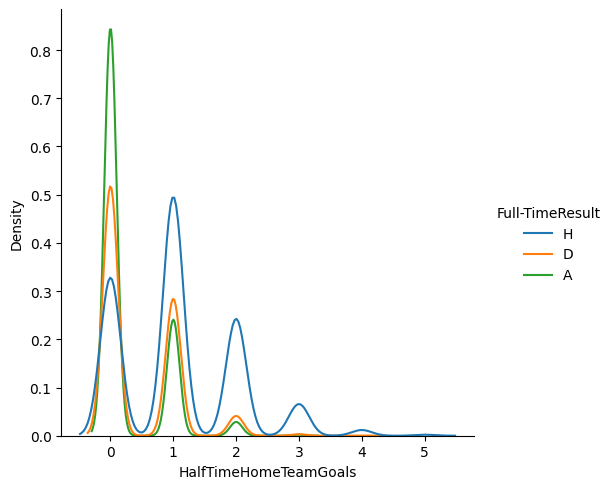

In [29]:
%matplotlib inline
sns.displot(train_data, x='HalfTimeHomeTeamGoals',hue='Full-TimeResult',kind="kde")
plt.show()

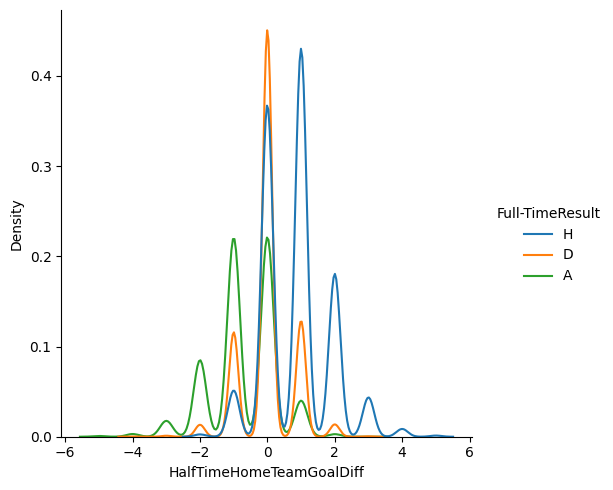

In [30]:
%matplotlib inline
sns.displot(train_data, x='HalfTimeHomeTeamGoalDiff',hue='Full-TimeResult',kind="kde")
plt.show()

### Observation : If by half time home team is having a higher number of goals than away team, then it is more probable to win

### Only categorical column to convert is 'league'

#### Run chi-squared test to see if the feature may be discarded following agreement to null hypothesis

In [31]:
from scipy.stats import chi2_contingency

In [32]:
contigency= pd.crosstab(train_data['Full-TimeResult'], train_data['league'])
contigency

league,bundesliga,la-liga,ligue-1,premier-league,serie-a
Full-TimeResult,,,,,
A,644,733,713,743,731
D,533,624,733,692,700
H,965,1303,1211,1225,1226


In [33]:
c, p, dof, expected = chi2_contingency(contigency)

In [34]:
p

0.010051661356323145

#### As p-value is 0.01, we can not reject the feature - so have to dummify it

#### Seperate out all numeric features first

In [35]:
model_data_numeric = train_data[extended_list_of_numeric_features]

#### Dummyfy categorical feature and join back with model data

In [36]:
dummies_data = pd.get_dummies(train_data.league)
model_data_combined = pd.concat([model_data_numeric, dummies_data],axis=1)

#### Define target for model data

In [37]:

model_data_combined['Target'] = train_data['Full-TimeResult']

#### Define model input features

In [38]:
model_input_features = list(model_data_combined.columns.drop('Target'))

In [39]:
len(model_input_features)

27

In [40]:
model_input_features

['HalfTimeHomeTeamGoals',
 'HalfTimeAwayTeamGoals',
 'HomeTeamShots',
 'AwayTeamShots',
 'HomeTeamShotsonTarget',
 'AwayTeamShotsonTarget',
 'AwayTeamCorners',
 'HomeTeamFoulsCommitted',
 'AwayTeamFoulsCommitted',
 'HomeTeamCorners',
 'HomeTeamYellowCards',
 'AwayTeamYellowCards',
 'HomeTeamRedCards',
 'AwayTeamRedCards',
 'HalfTimeHomeTeamGoalDiff',
 'HomeTeamShotsOntargetRatio',
 'AwayTeamShotsOntargetRatio',
 'HomeTeamTotalCards',
 'AwayTeamTotalCards',
 'HomeTeamCornersRatio',
 'HomeTeamFoulsRatio',
 'HomeTeamShotsOntargetUpliftThanAwayTeam',
 'bundesliga',
 'la-liga',
 'ligue-1',
 'premier-league',
 'serie-a']

## Feature engineering complete

## Modelling

#### Install lightgbm

In [41]:
!pip install lightgbm


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Import packages for modelling

In [42]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV

from sklearn.metrics import *

import lightgbm as lgb

#### Split dataset in train-test set with 80:20 ratio

In [43]:
X_train, X_test, y_train, y_test = train_test_split(model_data_combined, model_data_combined.Target, test_size=0.2, random_state=42)

#### Scale input variables

In [44]:
scaler = MinMaxScaler()
scaler.fit(X_train[model_input_features])
X_train_scaled = scaler.transform(X_train[model_input_features])
X_test_scaled = scaler.transform(X_test[model_input_features])

#### Label encode target column

In [45]:
enc = LabelEncoder()
enc_fitted = enc.fit(y_train)
y_train_encoded = enc_fitted.transform(y_train)
y_test_encoded = enc_fitted.transform(y_test)

#### Define model object

In [46]:
classifier = lgb.LGBMClassifier(
            objective= 'multiclass',metric='multi_error',n_jobs=-1,
            num_class=3,
            n_estimators = 500)

#### Define grid search parameters and cross validation

In [47]:
grid_param = {
    'subsample': [0.5,0.6,0.7,0.8],
    'max_depth': [3,4,5,7,9],
    'feature_fraction': [0.5,0.6,0.7,0.8],
    'learning_rate' : [0.008,1e-5,1e-6]
}

#### Setting best parameter for final model 
# # {'feature_fraction': 0.6, 'learning_rate': 0.008, 'max_depth': 4, 'subsample': 0.5}
# grid_param = {
#     'subsample': [0.5],
#     'max_depth': [4],
#     'feature_fraction': [0.6],
#     'learning_rate' : [0.008]
# }

model_grid = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=4,
                     n_jobs=-1)

In [48]:
import time

#### Train model with cv and grid-search

In [49]:
start_time = time.time()

model_grid.fit(X_train_scaled, y_train_encoded)
end_time = time.time()

print('time taken to train :',end_time-start_time)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
time taken to train : 13.658999681472778


#### What are the best parameters?

In [50]:
best_parameters = model_grid.best_params_
print(best_parameters)

{'feature_fraction': 0.6, 'learning_rate': 0.008, 'max_depth': 4, 'subsample': 0.5}


In [51]:
model_grid.best_estimator_

LGBMClassifier(feature_fraction=0.6, learning_rate=0.008, max_depth=4,
               metric='multi_error', n_estimators=500, num_class=3,
               objective='multiclass', subsample=0.5)

#### Predict train and test data and calculate accuracy

In [52]:

pred_train = model_grid.predict(X_train_scaled)
pred_test = model_grid.predict(X_test_scaled)

print('train set accuracy : ',accuracy_score(y_train_encoded,pred_train))
print('test set accuracy : ',accuracy_score(y_test_encoded,pred_test))


train set accuracy :  0.6822896281800391
test set accuracy :  0.6647104851330203


#### Best model:
    train set accuracy :  68%
    test set accuracy :  66%

#### Save model artefacts and list of input features for future use

In [53]:
import joblib

In [54]:
joblib.dump(model_grid.best_estimator_, 'trained_model.pkl')
joblib.dump(enc_fitted, 'target_encoder.pkl')
joblib.dump(scaler, 'fitted_scaler.pkl')
joblib.dump(extended_list_of_numeric_features, 'list_of_numeric_features')
joblib.dump(model_input_features, 'list_of_all_input_features')

['list_of_all_input_features']

## Here we can see model is robust, not overfitting (due to cross validation tests)
### We can expect the model to perform with 66%-68% accuracy over unseen data

#### Create confusion matrix

In [55]:
y_pred_test = enc_fitted.inverse_transform(pred_test)
conf_mat = confusion_matrix(y_test, y_pred_test)
conf_mat_df = pd.DataFrame(conf_mat,
                     index = ['Away_Win','Draw','Home_Win'], 
                     columns = ['Away_Win','Draw','Home_Win'])



#### Plot hitmap with conf-matrix

Text(0.5, 14.581597222222216, 'Predicted Results')

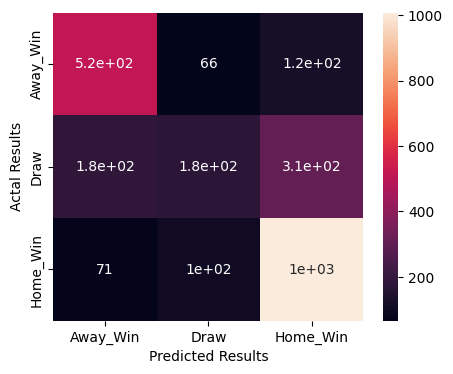

In [56]:
plt.figure(figsize=(5,4))
sns.heatmap(conf_mat_df, annot=True)
plt.ylabel('Actal Results')
plt.xlabel('Predicted Results')

In [57]:
conf_mat_df

,Away_Win,Draw,Home_Win
Away_Win,516,66,124
Draw,185,175,308
Home_Win,71,103,1008


### Calculate prevalance and model precision
#### Ideally if model is better than "random guess", then precision would be higher than prevalance

In [58]:
print("=====Home Win======")
home_win_prevalance = y_test.value_counts()[0]/len(y_test)
print('home_win_prevalance:',home_win_prevalance)
home_win_precision = conf_mat_df['Home_Win']['Home_Win']/np.sum(conf_mat_df['Home_Win'])
print('home_win_precision:',home_win_precision)
print('home_win_uplift_by_model:',home_win_precision/home_win_prevalance)

print("=====Away Win======")
away_win_prevalance = y_test.value_counts()[1]/len(y_test)
print('away_win_prevalance:',away_win_prevalance)
away_win_precision = conf_mat_df['Away_Win']['Away_Win']/np.sum(conf_mat_df['Away_Win'])
print('away_win_precision:',away_win_precision)
print('away_win_uplift_by_model:',away_win_precision/away_win_prevalance)

print("=====Draw======")
draw_prevalance = y_test.value_counts()[2]/len(y_test)
print('draw_prevalance:',draw_prevalance)
draw_precision = conf_mat_df['Draw']['Draw']/np.sum(conf_mat_df['Draw'])
print('draw_precision:',draw_precision)
print('draw_uplift_by_model:',draw_precision/draw_prevalance)

=====Home Win======
home_win_prevalance: 0.4624413145539906
home_win_precision: 0.7
home_win_uplift_by_model: 1.5137055837563451
=====Away Win======
away_win_prevalance: 0.2762128325508607
away_win_precision: 0.6683937823834197
away_win_uplift_by_model: 2.419850577580766
=====Draw======
draw_prevalance: 0.26134585289514867
draw_precision: 0.5087209302325582
draw_uplift_by_model: 1.9465429605904472



## Model is having clear uplift from baseline random guess

    - Home team win uplift by ~1.5 times
    - Away team win uplift by ~2.4 times
    - Draw uplift by ~2 times


## Feature importance analysis

#### Feature importance from lightgbm model

Create feature importance dataframe with features and their correspnsing importance

In [59]:
feat_imp_df = pd.DataFrame(list(zip(model_input_features,list(model_grid.best_estimator_.feature_importances_))),columns=['feature_name','importance'])

Get top features (having 95% weight in importance

In [60]:
feat_imp_df = feat_imp_df.sort_values('importance',ascending=False)
feat_imp_df['cumulative_importance'] = feat_imp_df['importance'].cumsum()
total_importance = np.max(feat_imp_df['cumulative_importance'])
feat_imp_df['pct_of_imp_captured'] = feat_imp_df['cumulative_importance']/total_importance
feat_imp_df[feat_imp_df['pct_of_imp_captured']<=0.95].shape


(19, 4)

In [61]:
feat_imp_df[feat_imp_df['pct_of_imp_captured']<=0.95]['feature_name'].values

array(['HalfTimeHomeTeamGoalDiff',
       'HomeTeamShotsOntargetUpliftThanAwayTeam', 'AwayTeamShotsonTarget',
       'HomeTeamShotsonTarget', 'AwayTeamShots', 'HomeTeamShots',
       'HomeTeamShotsOntargetRatio', 'AwayTeamShotsOntargetRatio',
       'HomeTeamCornersRatio', 'HalfTimeHomeTeamGoals',
       'HalfTimeAwayTeamGoals', 'AwayTeamRedCards', 'HomeTeamFoulsRatio',
       'HomeTeamRedCards', 'AwayTeamFoulsCommitted', 'AwayTeamCorners',
       'HomeTeamCorners', 'HomeTeamTotalCards', 'AwayTeamTotalCards'],
      dtype=object)

#### Hence, there are 19 features which is imparting 95% weightage on feature importance

#### Feature importance using SHAP

Create SHAP tree explainer

In [62]:
explainer = shap.TreeExplainer(model_grid.best_estimator_)
shap_values = explainer.shap_values(X_train[model_input_features])

SHAP summary plot

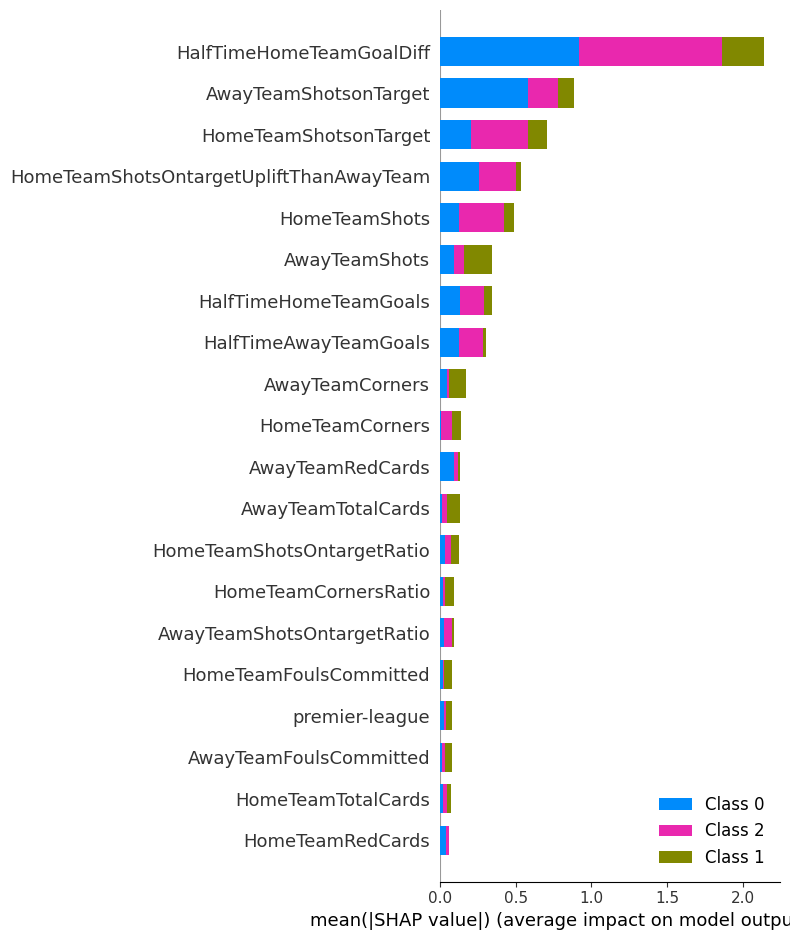

In [63]:
shap.summary_plot(shap_values, X_train[model_input_features], feature_names=model_input_features, plot_type="bar")

### Plot density curves for few features

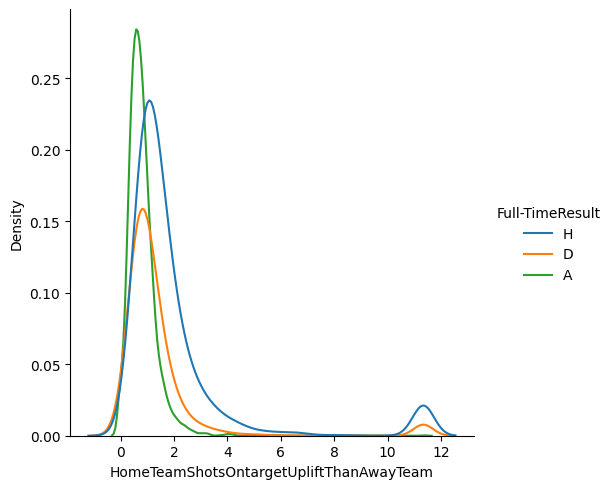

In [64]:
%matplotlib inline
sns.displot(train_data, x='HomeTeamShotsOntargetUpliftThanAwayTeam',hue='Full-TimeResult',kind="kde")
plt.show()

#### Observation : If percentage of shots-on-target for home team is higher by ~1.75 times or more than that of away team,there is a higher probability for home team wins 

## Model execution with test data

#### Read test data

In [65]:
test_data = pd.read_csv('../test-3.csv',index_col=False)

In [66]:
test_data.columns

Index(['index', 'AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'Date', 'HC',
       'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HY', 'HomeTeam', 'Referee',
       'league'],
      dtype='object')

In [67]:
test_data = test_data.drop('index',axis = 1)

#### Step - 1 : Convert column names to meaningful names

In [68]:
test_data = convert_column_names(test_data,old_col_names = list_of_old_column_names,new_col_names = list_of_meaningful_column_name)

#### Step 2 : Run feature engineering by applying pre-defined functions

In [69]:
test_data = feat_eng_create_derived_feats(test_data)
test_data = feat_eng_convert_date_to_format(test_data)

In [70]:
test_data.columns

Index(['AwayTeam', 'HomeTeam', 'Referee', 'league', 'HalfTimeHomeTeamGoals',
       'HalfTimeAwayTeamGoals', 'HomeTeamShots', 'AwayTeamShots',
       'HomeTeamShotsonTarget', 'AwayTeamShotsonTarget', 'AwayTeamCorners',
       'HomeTeamFoulsCommitted', 'AwayTeamFoulsCommitted', 'HomeTeamCorners',
       'HomeTeamYellowCards', 'AwayTeamYellowCards', 'HomeTeamRedCards',
       'AwayTeamRedCards', 'HalfTimeHomeTeamGoalDiff',
       'HomeTeamShotsOntargetRatio', 'AwayTeamShotsOntargetRatio',
       'HomeTeamTotalCards', 'AwayTeamTotalCards', 'HomeTeamCornersRatio',
       'HomeTeamFoulsRatio', 'HomeTeamShotsOntargetUpliftThanAwayTeam',
       'date'],
      dtype='object')

#### Step 3 - Convert category to dummy data and create final feature set

In [71]:
model_data_numeric_test = test_data[extended_list_of_numeric_features]
dummies_data_test = pd.get_dummies(test_data.league)
model_data_test_combined = pd.concat([model_data_numeric_test, dummies_data_test],axis=1)

#### Step 4 - Scale input features and predict with trained model

In [72]:
model_test_scaled = scaler.transform(model_data_test_combined[model_input_features])
model_pred_test = model_grid.predict(model_test_scaled)

#### Step 5 - Reverse encode target predictions to get actual results (i,2, 'H','A' or 'D')

In [73]:
model_pred_test_result = enc_fitted.inverse_transform(model_pred_test)

#### Step 6 - Add the predictions column with original dataset

In [74]:
test_data['Prediction'] = model_pred_test_result

In [75]:
test_data

,AwayTeam,HomeTeam,Referee,league,HalfTimeHomeTeamGoals,HalfTimeAwayTeamGoals,HomeTeamShots,AwayTeamShots,HomeTeamShotsonTarget,AwayTeamShotsonTarget,...,HalfTimeHomeTeamGoalDiff,HomeTeamShotsOntargetRatio,AwayTeamShotsOntargetRatio,HomeTeamTotalCards,AwayTeamTotalCards,HomeTeamCornersRatio,HomeTeamFoulsRatio,HomeTeamShotsOntargetUpliftThanAwayTeam,date,Prediction
0,Leverkusen,Bayern Munich,NaN,bundesliga,2,0,13,19,8,4,...,2,0.615385,0.210526,1,2,0.444444,0.433333,2.923077,2017-08-18,H
1,Augsburg,Hamburg,NaN,bundesliga,1,0,11,13,5,1,...,1,0.454545,0.076923,4,3,0.300000,0.529412,5.909091,2017-08-19,H
2,Stuttgart,Hertha,NaN,bundesliga,0,0,10,9,3,2,...,0,0.300000,0.222222,2,1,0.833333,0.600000,1.350000,2017-08-19,D
3,Werder Bremen,Hoffenheim,NaN,bundesliga,0,0,14,11,3,2,...,0,0.214286,0.181818,1,3,0.600000,0.531250,1.178571,2017-08-19,D
4,Hannover,Mainz,NaN,bundesliga,0,0,14,6,6,2,...,0,0.428571,0.333333,3,5,0.928571,0.562500,1.285714,2017-08-19,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,Fiorentina,Milan,NaN,serie-a,2,1,18,9,11,3,...,1,0.611111,0.333333,2,2,0.857143,0.666667,1.833333,2018-05-20,H
1822,Crotone,Napoli,NaN,serie-a,2,0,19,9,9,4,...,2,0.473684,0.444444,0,0,0.400000,0.250000,1.065789,2018-05-20,H
1823,Roma,Sassuolo,NaN,serie-a,0,1,16,15,3,6,...,-1,0.187500,0.400000,1,1,0.357143,0.636364,0.468750,2018-05-20,A
1824,Sampdoria,Spal,NaN,serie-a,1,0,16,9,6,3,...,1,0.375000,0.333333,1,4,0.625000,0.476190,1.125000,2018-05-20,H


#### Save data file as csv

In [76]:
test_data.to_csv('model_test_predictions.csv')

In [77]:
test_data.shape